In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import model_selection

import pylab
import time
import random
import matplotlib.pyplot as plt


In [61]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide code cells."></form>''')

In [ ]:
HTML('''<script>
show_image = true;
function toggle_image(){
if (show_image){

}
}
if (show_image)''')

In [62]:
HTML('''<form action="javascript:code_toggle()"><input type="submit" value="Click here to show/hide code cells."></form>''')

# Detection of input drift using PSI

* Used publically available SEA dataset
* Has three features and 2 classes (0 and 1)
* Data set consists of 60,000 rows

In [2]:
def get_decile_dist(prediction_prob_matrix):
    prob_0 = prediction_prob_matrix[:,0]
    df_prob_0 = pd.DataFrame(prob_0, columns = ['prob_0'])
    conditions = [(df_prob_0.prob_0 >= 0.9),
          ((df_prob_0.prob_0 < 0.9) & (df_prob_0.prob_0 >= 0.8)),
          ((df_prob_0.prob_0 < 0.8) & (df_prob_0.prob_0 >= 0.7)),
          ((df_prob_0.prob_0 < 0.7) & (df_prob_0.prob_0 >= 0.6)),
          ((df_prob_0.prob_0 < 0.6) & (df_prob_0.prob_0 >= 0.5)),
          ((df_prob_0.prob_0 < 0.5) & (df_prob_0.prob_0 >= 0.4)),
          ((df_prob_0.prob_0 < 0.4) & (df_prob_0.prob_0 >= 0.3)),
          ((df_prob_0.prob_0 < 0.3) & (df_prob_0.prob_0 >= 0.2)),
          ((df_prob_0.prob_0 < 0.2) & (df_prob_0.prob_0 >= 0.1)),
          (df_prob_0.prob_0 < 0.1)]

    choices = np.arange(1,11)
    df_prob_0['decile'] = np.select(conditions, choices, default = 'none')
    df_prob_0['decile'] = df_prob_0['decile'].astype(int)
    decile_dist = df_prob_0.groupby('decile')[['prob_0']].count().reset_index().sort_values(by = 'decile')
    decile_dist['decile_dist_perc'] = np.round(100*decile_dist['prob_0']/decile_dist['prob_0'].sum(),1)
    return decile_dist

    

In [3]:
def calculate_PSI(training_set, serving_set, model_recv):
    predictions_train = model_recv.predict_proba(training_set)
    training_dist = get_decile_dist(predictions_train).rename(columns = {'prob_0' : 'train_dist', 
                                                                         'decile_dist_perc' : 'train_dist_perc'})
    predictions_serving = model_recv.predict_proba(serving_set)
    serving_dist = get_decile_dist(predictions_serving).rename(columns = {'prob_0' : 'serv_dist', 
                                                                          'decile_dist_perc' : 'serv_dist_perc'})
    merged = pd.merge(training_dist, serving_dist, on='decile', how ='inner')
    
    merged['s-t'] = merged['serv_dist_perc'] - merged['train_dist_perc']

    merged['ln(s/t)'] = np.log(merged['serv_dist_perc']/merged['train_dist_perc'])

    merged['PSI'] = merged['ln(s/t)'] * (merged['s-t']/100)

    return merged.PSI.sum()
    

In [4]:
def train_model(X,y):
    seed = 369
    test_size = 0.33
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
    model_new = LogisticRegression()
    model_new.fit(X_train, y_train)
    y_pred = model_new.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy after retraining: %.2f%%" % (accuracy * 100.0))
    return model_new,X_test
    
    

In [5]:
df = pd.read_csv('sea.csv', names = ['feature1','feature2','feature3','label'])

In [6]:
df.loc[15000:30000, 'feature3'] = df['feature3'] + 1
df.loc[30000:45000, 'feature2'] = df['feature2'] + 2
df.loc[45000:60000, 'feature3'] = df['feature3'] + 3

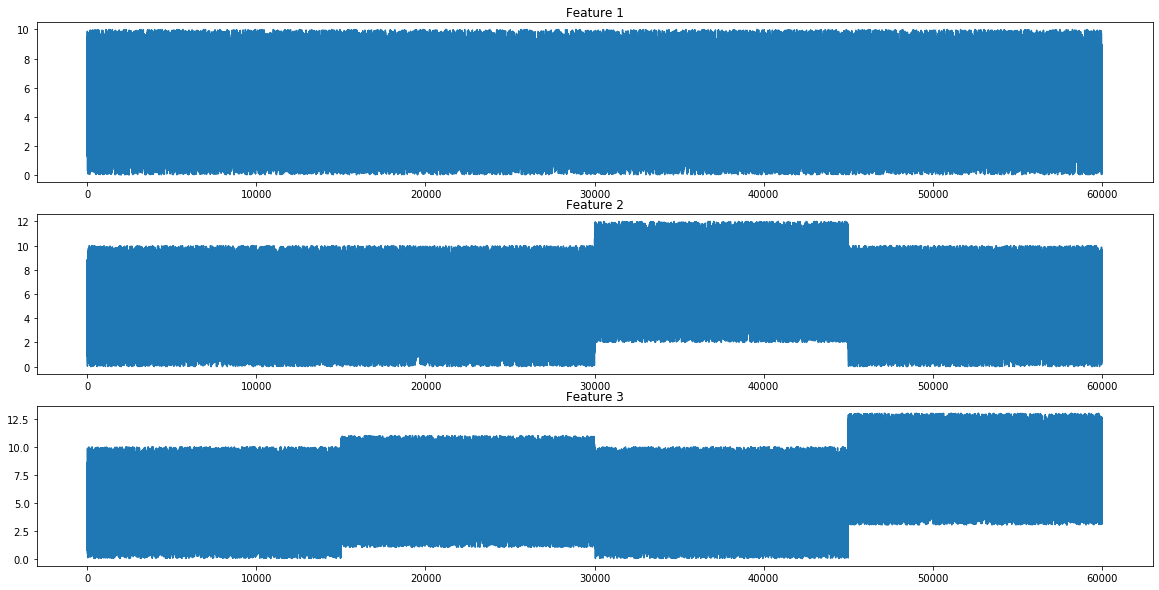

In [21]:
import matplotlib.pyplot as plt

# fig, ax = plt.subplots(nrows=1, ncols=3)
# features = ['feature1','feature2','feature3']

fig = plt.figure(figsize = (20,10))

plt.subplot(3, 1, 1)
plt.plot(df['feature1'], label = 'feature1')
plt.title('Feature 1')

plt.subplot(3, 1, 2)
plt.plot(df['feature2'], label = 'feature2')
plt.title('Feature 2')

plt.subplot(3, 1, 3)
plt.plot(df['feature3'], label = 'feature3')
plt.title('Feature 3')

# plt.subplot(2, 2, 4)
# plt.plot(x, y)

plt.show()

<img src="window.png">

# Train classifier (logistic regression) on first 15000 examples

In [23]:
df1 = df[0:15000]

In [24]:
X1 = df1[['feature1', 'feature2', 'feature3']].values
y1 = df1['label'].values
# split data into train and test sets
seed = 9
test_size = 0.33
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=seed)
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
# fit model no training data
model = LogisticRegression()
model.fit(X1_train, y1_train)
print(model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [25]:
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=4369)
cv_results = model_selection.cross_validate(model, X1_train, y1_train, cv=kfold, scoring=scoring)
clf = model.fit(X1_train, y1_train)
cv_results

{'fit_time': array([0.0149951 , 0.01404095, 0.01095867, 0.01199818, 0.01200271]),
 'score_time': array([0.00600243, 0.00599837, 0.00500059, 0.00499964, 0.0049994 ]),
 'test_accuracy': array([0.8840796 , 0.88756219, 0.89701493, 0.88756219, 0.8920398 ]),
 'test_precision_weighted': array([0.88419463, 0.88775362, 0.89781656, 0.88769167, 0.89201094]),
 'test_recall_weighted': array([0.8840796 , 0.88756219, 0.89701493, 0.88756219, 0.8920398 ]),
 'test_f1_weighted': array([0.88198861, 0.8853235 , 0.89513122, 0.8857093 , 0.89039305]),
 'test_roc_auc': array([0.85576631, 0.8717403 , 0.8775142 , 0.87908443, 0.89243298])}

## Average accuracy with cross validation (5 splits) on inititial test set

In [38]:
mean_acc = 100 * cv_results['test_accuracy'].mean()
print("The mean accuracy of model is %0.2f " %mean_acc) 

The mean accuracy of model is 88.97 


In [39]:
# make predictions for test data
y1_pred = model.predict(X1_test)
# predictions = [round(value) for value in y_pred]
predictions = model.predict_proba(X1_test)

## Monitor PSI  vs accuracy - without intervention

In [40]:

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

Initial model accuracy: 88.85%


<IPython.core.display.Javascript object>


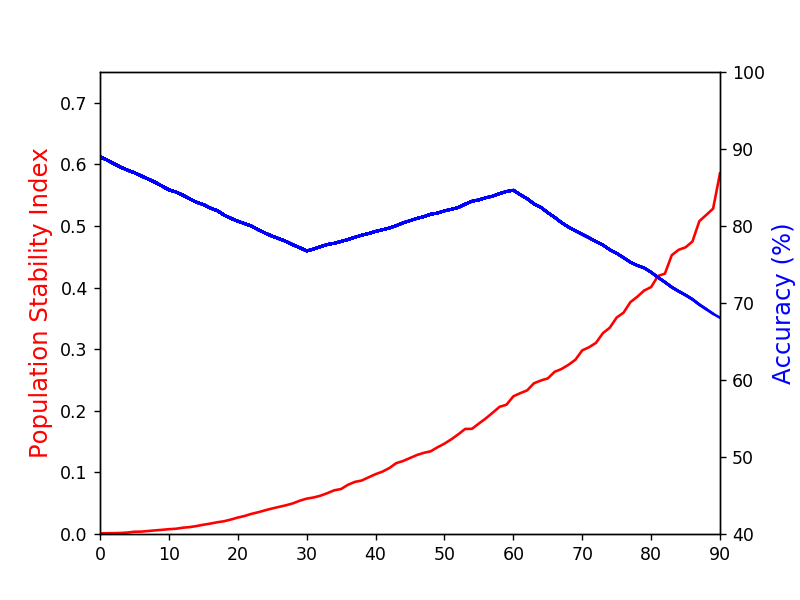

In [59]:
## Initiate model
df1 = df[0:15000]
X1 = df1[['feature1', 'feature2', 'feature3']].values
y1 = df1['label'].values
# split data into train and test sets
seed = 9
test_size = 0.33
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=seed)
# fit model no training data
model = LogisticRegression()
model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print("Initial model accuracy: %.2f%%" % (accuracy * 100.0))

batch_size = 500
window_size = 15000
# fig = plt.figure(figsize=(10,20))
fig = plt.figure()
ax  = fig.add_subplot(111)
ax2=ax.twinx()
plt.ion()

fig.show()
fig.canvas.draw()

PSIs = []
acc = []
for i in range(int((len(df)-window_size)/batch_size)+1):
    df_temp = df[(i*batch_size):((i*batch_size)+window_size)]
    X2 = df_temp[['feature1', 'feature2', 'feature3']].values
    y2 = df_temp['label'].values

    PSIs.append(calculate_PSI(X1_test,X2,model))
    y2_pred = model.predict(X2)
    acc.append((100*accuracy_score(y2, y2_pred)))
    ax.clear()
    ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax2.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax.set_ylim([0,0.75])
    ax2.set_ylim([40,100])
    ax.plot(range(len(PSIs)),PSIs, color = 'red')
    ax.set_ylabel("Population Stability Index",color="red",fontsize=14)
    ax2.plot(range(len(acc)),acc, color = 'blue')
    ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)

    fig.canvas.draw()
    plt.pause(0.00001)
    

## Monitor accuracy with intervention at PSI >0.05

Initial model accuracy: 89.27%


<IPython.core.display.Javascript object>


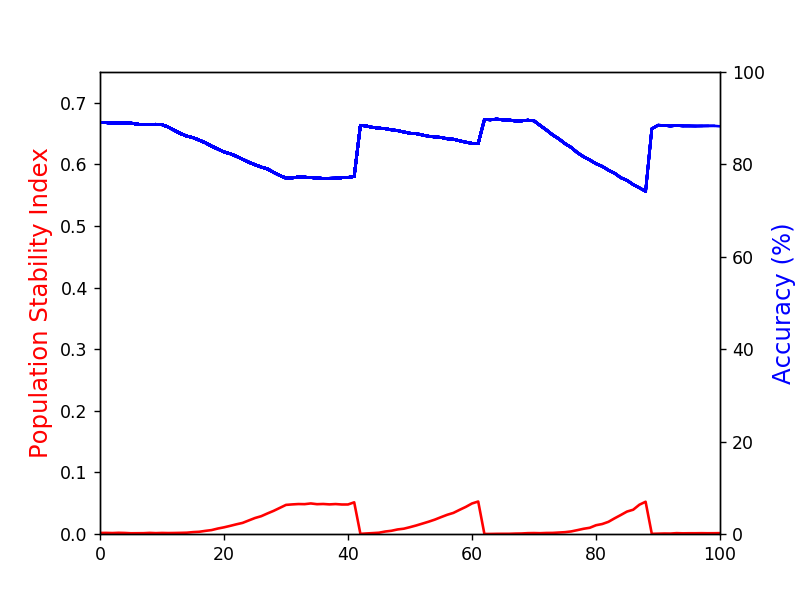

Accuracy after retraining: 88.88%
Accuracy after retraining: 89.79%
Accuracy after retraining: 86.97%


In [60]:
batch_size = 500
window_size = 10000
## Initiate model
df1 = df[0:window_size]
X1 = df1[['feature1', 'feature2', 'feature3']].values
y1 = df1['label'].values
# split data into train and test sets
seed = 9
test_size = 0.33
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=test_size, random_state=seed)
# fit model no training data
model = LogisticRegression()
model.fit(X1_train, y1_train)
y1_pred = model.predict(X1_test)
accuracy = accuracy_score(y1_test, y1_pred)
print("Initial model accuracy: %.2f%%" % (accuracy * 100.0))




# fig = plt.figure(figsize=(10,20))
fig = plt.figure()
ax  = fig.add_subplot(111)
ax2=ax.twinx()
plt.ion()

fig.show()
fig.canvas.draw()

PSIs = []
acc = []
for i in range(int((len(df)-window_size)/batch_size)+1):

    df_temp = df[(i*batch_size):((i*batch_size)+window_size)]
    X2 = df_temp[['feature1', 'feature2', 'feature3']].values
    y2 = df_temp['label'].values
#     PSIs.append(calculate_PSI(X1_test,df[i*batch_size,(i*batch_size)+window_size],model))
    PSI_new = calculate_PSI(X1_test,X2,model)
    PSIs.append(PSI_new)
    y2_pred = model.predict(X2)
#     print((100*accuracy_score(y2, y2_pred)))
    acc.append((100*accuracy_score(y2, y2_pred)))
    ax.clear()
    ax.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax2.set_xlim([0,int((len(df)-window_size)/batch_size)])
    ax.set_ylim([0,0.75])
    ax2.set_ylim([0,100])
    ax.plot(range(len(PSIs)),PSIs, color = 'red')
    ax.set_ylabel("Population Stability Index",color="red",fontsize=14)
    ax2.plot(range(len(acc)),acc, color = 'blue')
    ax2.set_ylabel("Accuracy (%)",color="blue",fontsize=14)

    fig.canvas.draw()
    plt.pause(0.001)
    
    if PSI_new>0.05:
        model,new_ref_df = train_model(X2,y2)
#         print("new PSI = ", calculate_PSI(X2,X2,model))
        X1_test = X2
        

        